# Detecting malicious URLs
Some introduction...

## Data exploration and cleaning

### General dataset information

In [36]:
DATASET_PATH = 'datasets/malicious_urls.csv'

In [37]:
import pandas as pd

df = pd.read_csv(DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [38]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [39]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [40]:
# Remove duplicates
df.drop_duplicates(inplace=True, subset=['url'], keep='last')
count = df.type.value_counts()
count

benign        428074
defacement     95308
phishing       94092
malware        23645
Name: type, dtype: int64

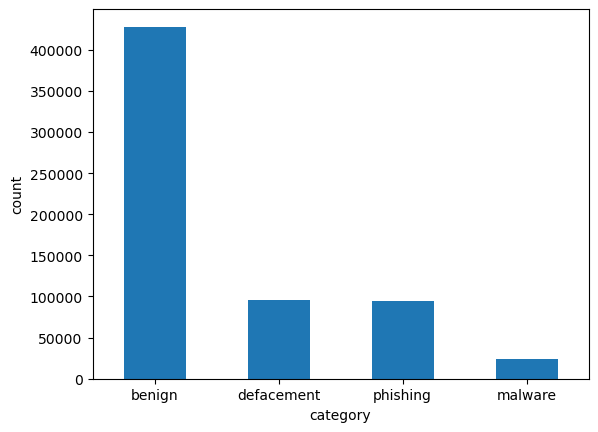

In [41]:
import matplotlib.pyplot as plt
count.plot.bar()
plt.xticks(rotation=0)
plt.xlabel("category")
plt.ylabel("count")
plt.show()

### Character encoding

In [42]:
# Detect character encoding
import chardet

encodings = df['url'].apply(lambda x: chardet.detect(str(x).encode('utf-8')))
df['encoding'] = encodings.apply(lambda x: x['encoding'])
df['enc_confidence'] = encodings.apply(lambda x: x['confidence'])
df.head(10)

,url,type,encoding,enc_confidence
0,br-icloud.com.br,phishing,ascii,1.0
1,mp3raid.com/music/krizz_kaliko.html,benign,ascii,1.0
2,bopsecrets.org/rexroth/cr/1.htm,benign,ascii,1.0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,ascii,1.0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,ascii,1.0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,ascii,1.0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,ascii,1.0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,ascii,1.0
8,http://www.pashminaonline.com/pure-pashminas,defacement,ascii,1.0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,ascii,1.0


In [43]:
# By trying some queries we observe that there are some URL strings with broken encoding
df.query(expr='encoding not in ("ascii" , "utf-8")')

,url,type,encoding,enc_confidence
4491,citizendia.org/Agence_métropolitaine_de_transport,benign,ISO-8859-9,0.629187
7564,wn.com/HYMNE_NATIONAL_DU_QUÉBEC,benign,Windows-1252,0.730000
8116,forum.verygames.net/showthread.php?42812-Probl...,benign,MacRoman,0.635195
14053,dictionary.sensagent.com/jehane+benoît/fr-fr/,benign,ISO-8859-9,0.682751
14853,dictionary.sensagent.com/université+de+sherbro...,benign,MacRoman,0.621045
...,...,...,...,...
573492,ÆÖY'uEdS*Z£ñ>7ñV\pìnY÷¡ß¬á'×?...,phishing,TIS-620,0.210592
573495,ùAyéTôDpFc~h@^¶\øâèû¥ÊÞG·ê(Tøì\0«Y=D ...,phishing,None,0.000000
573499,=Rãmôj³{è!ÀM¶6<N>w ¼Cf£]4ÍnÝÌ,phishing,None,0.000000
573507,«Düéºþ +ZIdN Ö-lh9L©hDKÄúhßÆ%YqÃ±¹d,phishing,None,0.000000


In [44]:
# Attempt to fix some broken encoding ("mojibake")
from ftfy import fix_encoding

df_fixed = pd.DataFrame()
df_fixed['url'] = df['url']
df_fixed['url_fixed'] = df_fixed['url'].apply(fix_encoding)
df_fixed.query(expr='url != url_fixed')

,url,url_fixed
44274,zoominfo.com/people/de%20GrandprÃ©_Jean_344774...,zoominfo.com/people/de%20Grandpré_Jean_3447745...
61961,http://www.scsrxx.com/js/?https://secure.runes...,http://www.scsrxx.com/js/?https://secure.runes...
126643,zoominfo.com/people/Sagan_FranÃƒÆ’Ã‚Â§oise_147...,zoominfo.com/people/Sagan_Françoise_1473040483...
300255,castroller.com/podcasts/CanaluPodcasts3/128646...,castroller.com/podcasts/CanaluPodcasts3/128646...
360359,zoominfo.com/people/SÃ©vigny_Danielle_15449882...,zoominfo.com/people/Sévigny_Danielle_154498825...
...,...,...
573506,r $ÐcYõ,r $Ðc˜‚Yõ
573507,«Düéºþ +ZIdN Ö-lh9L©hDKÄúhßÆ%YqÃ±¹d,«Dü‘éºþ +ZIdN Ö-lh9L©hŽDKÄúhßÆ%Yqñ¹d
573508,Þ~³\(ÿÇ½Jú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B ÇÈc2...,އ~³„Ÿ\(ÿǽJú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B…ǆÈc2#S...
573509,"ëËl×uÏB'JI¨GÙn""Ç( 0","ëËl×uÏB'JI¨GÙn""Ç(…0"


In [45]:
# Commit changes and check for strings that are still broken
df['url'] = df_fixed['url_fixed']
df.query('enc_confidence < 0.5')    # Includes all unidentified encodings

,url,type,encoding,enc_confidence
573417,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,phishing,None,0.000000
573418,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,phishing,None,0.000000
573422,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,phishing,TIS-620,0.264226
573424,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,Windows-1254,0.490066
573425,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,Windows-1252,0.228806
573427,>Iq9E) l¬0™ZÝìÃw!'Ôp£ãW§&£Ñ p&$ImÞôöÝYÖ,phishing,TIS-620,0.257015
573429,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,TIS-620,0.203882
573430,"˜ ꭛~l‡+×û¢ïÄÁŒR""+íI",phishing,None,0.000000
573431,ŠRybjUxÙãl5»7ÆE%ÝÔk+h |U+ýk©ìɔ½“Æq]âF·žõÁ...,phishing,None,0.000000
573432,§¬I0f9ÎPðÏ}åç`.7õú X '˜}—؁4~æʸa(_à,phishing,TIS-620,0.335509


In [46]:
# It seems there is an interval of rows where these invalid urls are concentrated
df.loc[573418:573510]

,url,type,encoding,enc_confidence
573418,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,phishing,None,0.000000
573419,'www.institutocgr.coo/web/media/syqvem/dk-óij...,phishing,Windows-1252,0.730000
573420,Yìê‡ koãջΧDéÎl½ñ¡ââqtò¸/à; Í,phishing,utf-8,0.990000
573421,虠kvüDâQÎé4¼ÒŽ©,benign,utf-8,0.990000
573422,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,phishing,TIS-620,0.264226
...,...,...,...,...
573506,r $Ðc˜‚Yõ,phishing,utf-8,0.990000
573507,«Dü‘éºþ +ZIdN Ö-lh9L©hŽDKÄúhßÆ%Yqñ¹d,phishing,None,0.000000
573508,އ~³„Ÿ\(ÿǽJú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B…ǆÈc2#S...,phishing,None,0.000000
573509,"ëËl×uÏB'JI¨GÙn""Ç(…0",phishing,utf-8,0.990000


In [47]:
# Remove urls we can't fix
df.drop(df.loc[573418:573510].index, inplace=True)

In [48]:
# Remove enc_confidence as it will not be needed for training
df.drop('enc_confidence', axis=1, inplace=True)
df.head(10)

,url,type,encoding
0,br-icloud.com.br,phishing,ascii
1,mp3raid.com/music/krizz_kaliko.html,benign,ascii
2,bopsecrets.org/rexroth/cr/1.htm,benign,ascii
3,http://www.garage-pirenne.be/index.php?option=...,defacement,ascii
4,http://adventure-nicaragua.net/index.php?optio...,defacement,ascii
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,ascii
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,ascii
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,ascii
8,http://www.pashminaonline.com/pure-pashminas,defacement,ascii
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,ascii


### Prepare URLs for parsing

In [49]:
import re

# Add // before every URL so that urllib.parse can detect the netloc part correctly (https://docs.python.org/3/library/urllib.parse.html#urllib.parse.urlparse)
df['url'] = df['url'].apply(lambda x: '//' + str(x) if not re.match(pattern="^.*\/\/", string=str(x)) else str(x))
df.head(10)

,url,type,encoding
0,//br-icloud.com.br,phishing,ascii
1,//mp3raid.com/music/krizz_kaliko.html,benign,ascii
2,//bopsecrets.org/rexroth/cr/1.htm,benign,ascii
3,http://www.garage-pirenne.be/index.php?option=...,defacement,ascii
4,http://adventure-nicaragua.net/index.php?optio...,defacement,ascii
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,ascii
6,//espn.go.com/nba/player/_/id/3457/brandon-rush,benign,ascii
7,//yourbittorrent.com/?q=anthony-hamilton-soulife,benign,ascii
8,http://www.pashminaonline.com/pure-pashminas,defacement,ascii
9,//allmusic.com/album/crazy-from-the-heat-r16990,benign,ascii


In [50]:
from urllib.parse import urlparse

# Check if we have any exceptions while parsing
success = True
for url in df['url']:
    try:
        urlparse(url)
    except ValueError as e:
        success = False
        print(e)
if success :
    print('no errors.')

no errors.


In [51]:
# Check again for duplicates since we changed some urls
df.drop_duplicates(inplace=True, subset=['url'], keep='last')

## Feature extraction

In [52]:
df['length'] = df['url'].apply(lambda x: len(str(x)))

urls = df['url'].apply(urlparse)

df['hostname'] = urls.apply(lambda x: x.hostname)
df['port'] = urls.apply(lambda x: x.port).astype('string')
df['protocol'] = urls.apply(lambda x: x.scheme)
df['path'] = urls.apply(lambda x: x.path)
df['query'] = urls.apply(lambda x: x.query)
df['fragment'] = urls.apply(lambda x: x.fragment)

df.sample(10)

,url,type,encoding,length,hostname,port,protocol,path,query,fragment
321674,http://www.markeven.it/ricerche-di-mercato.html,defacement,ascii,47,www.markeven.it,<NA>,http,/ricerche-di-mercato.html,,
336988,//dictionary.sensagent.com/elizabeth+cady+stan...,benign,ascii,56,dictionary.sensagent.com,<NA>,,/elizabeth+cady+stanton/en-en/,,
178217,//members.westnet.com.au/dcollett/BARNETT.html,benign,ascii,46,members.westnet.com.au,<NA>,,/dcollett/BARNETT.html,,
547823,http://109.230.238.68/Senpai-Squad.nios2,malware,ascii,40,109.230.238.68,<NA>,http,/Senpai-Squad.nios2,,
521873,http://espaceclientv1.fr/Notice/orange/custome...,phishing,ascii,84,espaceclientv1.fr,<NA>,http,/Notice/orange/customer_center/customer-IDPP00...,,
594363,//lnk.co/yuk67i5i?ertert?rthrth?ERtert?hrthrth...,benign,ascii,70,lnk.co,<NA>,,/yuk67i5i,ertert?rthrth?ERtert?hrthrth?cesare.camboni@po...,
429867,//cursos.ead.senac.br/moodle/hn/sab/854665818.php,benign,ascii,49,cursos.ead.senac.br,<NA>,,/moodle/hn/sab/854665818.php,,
408831,//bigsoccer.com/forum/showthread.php?t=195183,benign,ascii,45,bigsoccer.com,<NA>,,/forum/showthread.php,t=195183,
176530,http://www.pinkplanetplasencia.es/index.php?op...,defacement,ascii,90,www.pinkplanetplasencia.es,<NA>,http,/index.php,option=com_content&view=article&id=2&Itemid=41,
307754,http://www.ekino-neureut.de/index.php?option=c...,defacement,ascii,150,www.ekino-neureut.de,<NA>,http,/index.php,option=com_phocagallery&view=detail&catid=32:k...,


In [53]:
from urllib.parse import parse_qs

df['query_length'] = df['query'].apply(lambda x: len(str(x)))

df['query_args'] = df['query'].apply(lambda x: len(parse_qs(x)))

df.sample(10)

,url,type,encoding,length,hostname,port,protocol,path,query,fragment,query_length,query_args
144111,http://www.ksv-oestringen.de/index.php?option=...,defacement,ascii,89,www.ksv-oestringen.de,<NA>,http,/index.php,option=com_content&view=archive&year=2011&mont...,,50,4
255612,//crosswordcorner.blogspot.com/2011/08/sunday-...,benign,ascii,78,crosswordcorner.blogspot.com,<NA>,,/2011/08/sunday-august-7-2011-donna-s-levin.html,,,0,0
625290,//www.publish.com/c/a/Graphics-Tools/Five-usab...,phishing,ascii,78,www.publish.com,<NA>,,/c/a/Graphics-Tools/Five-usability-principles-...,,,0,0
98368,//s9.com/Biography/Austin-Steve,benign,ascii,31,s9.com,<NA>,,/Biography/Austin-Steve,,,0,0
77026,//joshua.co.il/,benign,ascii,15,joshua.co.il,<NA>,,/,,,0,0
51247,http://aksniwka.com/klub/wadze-klubu,defacement,ascii,36,aksniwka.com,<NA>,http,/klub/wadze-klubu,,,0,0
369336,http://www.alfacod.com.tr/wp-content/uploads/w...,phishing,ascii,125,www.alfacod.com.tr,<NA>,http,/wp-content/uploads/wysija/espace.reversement/...,,,0,0
260220,//opkansas.org/City-Government/Police-Station-...,benign,ascii,51,opkansas.org,<NA>,,/City-Government/Police-Station-Tours,,,0,0
11644,//disneychannel.wikia.com/wiki/Disney_Channel_...,benign,ascii,51,disneychannel.wikia.com,<NA>,,/wiki/Disney_Channel_Games,,,0,0
586700,//us.battle.net.login.uuwow.asia/login/en/logi...,benign,ascii,52,us.battle.net.login.uuwow.asia,<NA>,,/login/en/login.html,,,0,0


In [54]:
from pathlib import Path

df['path_length'] = df['path'].apply(lambda x: len(str(x)))

df['path_depth'] = df['path'].apply(lambda x: len(Path(str(x)).parents))

df.sample(10)

,url,type,encoding,length,hostname,port,protocol,path,query,fragment,query_length,query_args,path_length,path_depth
590993,//www.aikidotraditional.ro/templates/FORM87SJ.php,benign,ascii,49,www.aikidotraditional.ro,<NA>,,/templates/FORM87SJ.php,,,0,0,23,2
446126,//weather.yahoo.com/south-africa/mpumalanga/wi...,benign,ascii,60,weather.yahoo.com,<NA>,,/south-africa/mpumalanga/witbank-1591643/,,,0,0,41,3
517787,//thereddotgallery.com/jeff_cornell.asp?Artist...,benign,ascii,50,thereddotgallery.com,<NA>,,/jeff_cornell.asp,ArtistID=5,,10,1,17,1
493373,//wn.com/Alain_le_coach,benign,ascii,23,wn.com,<NA>,,/Alain_le_coach,,,0,0,15,1
447411,//surf.surftech.com/featured-boards/?bid=SURFB...,benign,ascii,131,surf.surftech.com,<NA>,,/featured-boards/,bid=SURFBDS+%3A+L1676-0706-MCT&type=SURFBDS&sh...,,94,3,17,1
397514,http://comicbook.com/2015/01/20/chris-evans-an...,benign,ascii,97,comicbook.com,<NA>,http,/2015/01/20/chris-evans-and-chris-pratt-exchan...,,,0,0,77,4
13601,//ebullition.com/Xhopscotch.html,benign,ascii,32,ebullition.com,<NA>,,/Xhopscotch.html,,,0,0,16,1
25506,http://besibajasby.com/tag/besi-unp/index.html,defacement,ascii,46,besibajasby.com,<NA>,http,/tag/besi-unp/index.html,,,0,0,24,3
116631,//ca.linkedin.com/pub/dir/Timothy/+/ca-4863-Mo...,benign,ascii,67,ca.linkedin.com,<NA>,,/pub/dir/Timothy/+/ca-4863-Montreal%2C-Canada-...,,,0,0,50,5
263469,http://schertzauto.com/wp-content/plugins/grav...,malware,ascii,88,schertzauto.com,<NA>,http,/wp-content/plugins/gravityforms/css/datepicke...,ver=1.9.11,,10,1,55,5


In [55]:
import ipaddress

df['hostname_lenght'] = df['hostname'].apply(lambda x: len(str(x)))

def is_ip(url):
    try:
        ip = ipaddress.ip_address(url)
    except:
        return False
    return str(ip) == url

df['has_ip'] = df['hostname'].apply(lambda x: is_ip(str(x)))

df['subdomains'] = df['hostname'].apply(lambda x: 0 if is_ip(str(x)) else len(re.findall(r'\.', str(x))))

df.query(expr='has_ip == True')

,url,type,encoding,length,hostname,port,protocol,path,query,fragment,query_length,query_args,path_length,path_depth,hostname_lenght,has_ip,subdomains
5719,//77.228.191.183:7674/zeujuus/a/modules/config...,malware,ascii,50,77.228.191.183,7674.0,,/zeujuus/a/modules/config.bin,,,0,0,29,4,14,True,0
10408,http://219.232.244.89/intl/update/error_login.htm,phishing,ascii,49,219.232.244.89,<NA>,http,/intl/update/error_login.htm,,,0,0,28,3,14,True,0
14915,http://66.208.115.70/images/index.asp,phishing,ascii,37,66.208.115.70,<NA>,http,/images/index.asp,,,0,0,17,2,13,True,0
15909,http://107.21.154.157/recordings/locale/.../my...,phishing,ascii,78,107.21.154.157,<NA>,http,/recordings/locale/.../my.screenname.aol.com/l...,,,0,0,57,5,14,True,0
22245,//216.92.161.171/vb/printthread.php?t=8432&pp=...,benign,ascii,55,216.92.161.171,<NA>,,/vb/printthread.php,t=8432&pp=40&page=2,,19,3,19,2,14,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555181,http://211.137.225.95:47475/Mozi.m,malware,ascii,34,211.137.225.95,47475.0,http,/Mozi.m,,,0,0,7,1,14,True,0
555182,http://115.55.246.246:44661/Mozi.m,malware,ascii,34,115.55.246.246,44661.0,http,/Mozi.m,,,0,0,7,1,14,True,0
555183,http://219.155.142.211:55621/Mozi.m,malware,ascii,35,219.155.142.211,55621.0,http,/Mozi.m,,,0,0,7,1,15,True,0
555184,http://42.238.164.8:48848/Mozi.m,malware,ascii,32,42.238.164.8,48848.0,http,/Mozi.m,,,0,0,7,1,12,True,0


In [57]:
df['has_urlencoded_char'] = df['url'].apply(lambda x: True if '%' in str(x) else False)



df.sample(10)

,url,type,encoding,length,hostname,port,protocol,path,query,fragment,query_length,query_args,path_length,path_depth,hostname_lenght,has_ip,subdomains,has_urlencoded_char
614213,//www.cs.cornell.edu/People/tj/,phishing,ascii,31,www.cs.cornell.edu,<NA>,,/People/tj/,,,0,0,11,2,18,False,3,False
65360,//boatshowandmore.com/bsam/,benign,ascii,27,boatshowandmore.com,<NA>,,/bsam/,,,0,0,6,1,19,False,1,False
20863,http://www.borlangedance.se/index.php?option=c...,defacement,ascii,137,www.borlangedance.se,<NA>,http,/index.php,option=com_content&view=article&id=119:dansklu...,,99,4,10,1,20,False,2,False
438255,http://www.expatsalon.ru/index.php/2009-03-04-...,defacement,ascii,73,www.expatsalon.ru,<NA>,http,/index.php/2009-03-04-07-24-36/111--academie.html,,,0,0,49,3,17,False,2,False
358679,http://www.linohome.gr/index.php?option=com_vi...,defacement,ascii,94,www.linohome.gr,<NA>,http,/index.php,option=com_virtuemart&view=category&virtuemart...,,61,3,10,1,15,False,2,False
409360,//empireco.co.za/,benign,ascii,17,empireco.co.za,<NA>,,/,,,0,0,1,0,14,False,2,False
347160,//amazon.com/Bob-Dylan-Performing-Artist-Beyon...,benign,ascii,61,amazon.com,<NA>,,/Bob-Dylan-Performing-Artist-Beyond/dp/1844492818,,,0,0,49,3,10,False,1,False
469839,https://twitter.com/share?text=%D0%A4%D0%BE%D1...,benign,ascii,224,twitter.com,<NA>,https,/share,text=%D0%A4%D0%BE%D1%82%D0%BE%D0%BF%D0%BE%D0%B...,,198,2,6,1,11,False,1,True
570629,//rekrims.com/PLO5XIde/webscr.php?cmd_=session...,benign,ascii,118,rekrims.com,<NA>,,/PLO5XIde/webscr.php,cmd_=session.start&sdr01=aW5mb0Bjc3NvZW0uZGU=&...,,84,4,20,2,11,False,1,False
285352,//pennsylvania.jobs.topusajobs.com/,benign,ascii,35,pennsylvania.jobs.topusajobs.com,<NA>,,/,,,0,0,1,0,32,False,3,False


### TODO

- Match hostnames in other parts of url (path/query)
- Match lookalike unicode characters
- Match URL shorteners
- Match specific words (admin, login, password...)

- For scheme, match only whether it has https or not
- Remove fragments (too few URLs have one)

- optional: WHOIS query
- optional: Try to detect XSS/SQL/code injection